In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [29]:
import tensorflow
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.models import Sequential
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping

In [31]:
from imutils import paths
import cv2
import mediapipe as mp
from tensorflow.keras.models import load_model
import os

In [32]:
pwd

'C:\\Users\\shail'

In [59]:
# Define the path to the extracted dataset directory
dataset_path = 'C:\\Users\\shail\\processed_images_greyscale'

# Load the dataset
dataset = tensorflow.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    image_size=(150, 150),
    batch_size=25
)

# Display class names
class_names = dataset.class_names
print(f"Class names: {class_names}")

Found 231 files belonging to 10 classes.
Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [34]:
for image_batch, label_batch in dataset.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.numpy())

Image batch shape: (25, 150, 150, 3)
Label batch shape: [2 1 1 8 5 2 4 8 2 2 8 4 9 0 5 3 9 4 1 9 4 0 1 8 1]


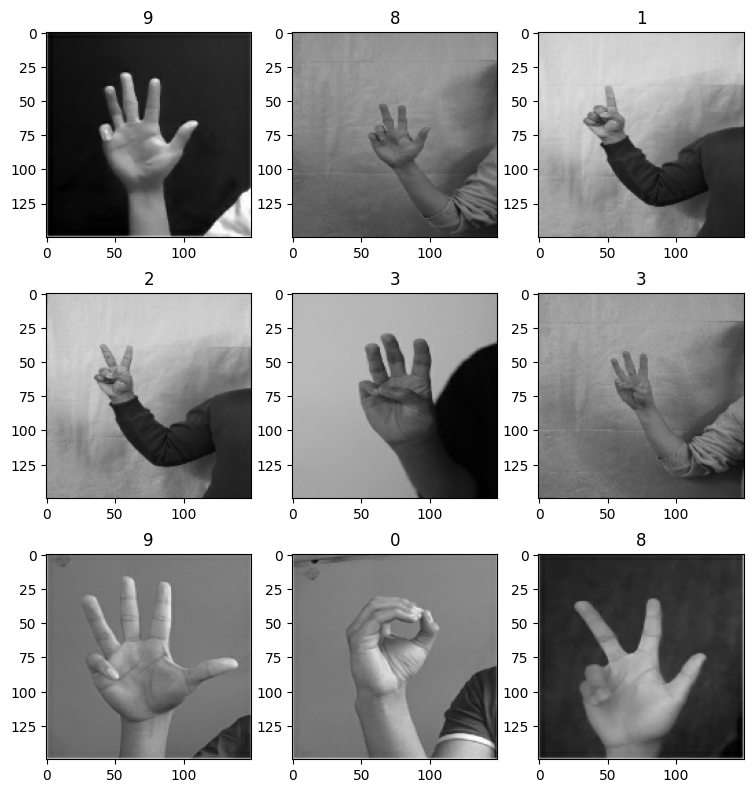

In [35]:
plt.figure(figsize=(9,13))
for image_batch, label_batch in dataset.take(1):
    for r in range(9):
        plot = plt.subplot(4,3,r+1)
        plt.imshow(image_batch[r].numpy().astype("uint8"))
        plt.title(class_names[label_batch[r]])


In [36]:
len(dataset)

10

In [37]:
train_data = .8
len(dataset)*train_data

8.0

In [38]:
train_data = dataset.take(8)
len(train_data)

8

In [39]:
test_data = .1
len(dataset)*test_data

1.0

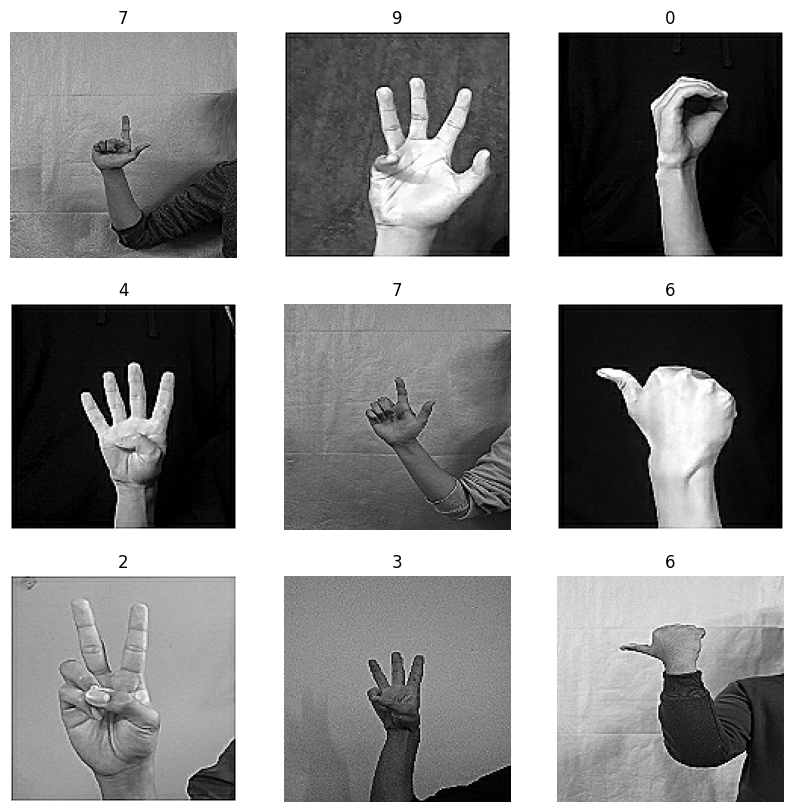

In [63]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Sharpening function
def sharpen_image(img):
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

# Function to apply sharpening to a batch of images
def sharpen_batch(images):
    sharpened_images = []
    for img in images:
        img_np = img.astype('uint8')  # Convert to uint8
        sharpened_img = sharpen_image(img_np)  # Apply sharpening
        sharpened_img = sharpened_img.astype('float32') / 255.0  # Normalize
        sharpened_images.append(sharpened_img)
    return np.array(sharpened_images)

# Apply sharpening to the dataset
sharpened_dataset = dataset.map(lambda x, y: (tf.numpy_function(sharpen_batch, [x], tf.float32), y))

# Display some sharpened images
plt.figure(figsize=(10, 10))
for images, labels in sharpened_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis('off')
plt.show()


In [67]:
def get_dataset_partitions_tf(ds, train_split = .8, val_split = .1, test_split = .1, shuffle = True, shuffle_size = 1000):

    ds_size  = len(dataset)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 10)
        train_size = int(train_split*ds_size)
        val_size = int(val_split*ds_size)

        train_ds  = ds.take(train_size)
        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size + val_size)

        return train_ds,val_ds, test_ds


train_ds, test_ds, val_ds  = get_dataset_partitions_tf(dataset)
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tensorflow.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = tensorflow.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = tensorflow.data.AUTOTUNE)

resize_rescale = tensorflow.keras.Sequential([
  layers.Resizing(64, 64),
  layers.Rescaling(1.0/255)
])
data_augmentation = tensorflow.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])


input_shape = (150,150,3)
n_classes = 10

resize_rescale
data_augmentation

model = models.Sequential([

    layers.Input(shape = input_shape),

    layers.Conv2D(32, (3,3),padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64,(3,3),padding='same',activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(64, (3,3),padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),


    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(10,activation='softmax')



])

model.summary()

model.compile(optimizer='adam',
             loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'] )
history = model.fit(train_ds,epochs=15, verbose = 1, validation_data = val_ds)
score = model.evaluate(test_ds)
score
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss  = history.history['val_loss']


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)             │ (None, 150, 150, 32)  │          896 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_6               │ (None, 75, 75, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_7 (Conv2D)             │ (None, 75, 75, 64)    │       18,496 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_7               │ (None, 37, 37, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_8 (Conv2D)             │ (None, 37, 37, 64)    │       36,928 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_8               │ (None, 18, 18, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_2 (Flatten)           │ (None, 20736)         │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_4 (Dense)               │ (None, 128)           │    2,654,336 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_5 (Dense)               │ (None, 10)            │        1,290 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 2,711,946 (10.35 MB)

 Trainable params: 2,711,946 (10.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 374ms/step - accuracy: 0.1215 - loss: 302.4940 - val_accuracy: 0.2400 - val_loss: 3.7187
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 328ms/step - accuracy: 0.1359 - loss: 2.6316 - val_accuracy: 0.2800 - val_loss: 2.1507
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 347ms/step - accuracy: 0.3197 - loss: 2.0894 - val_accuracy: 0.4000 - val_loss: 1.6310
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 345ms/step - accuracy: 0.4206 - loss: 1.7904 - val_accuracy: 0.5600 - val_loss: 1.4151
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 381ms/step - accuracy: 0.6045 - loss: 1.3522 - val_accuracy: 0.6800 - val_loss: 1.2747
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 390ms/step - accuracy: 0.6257 - loss: 1.1591 - val_accuracy: 0.7200 - val_loss: 1.1074
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 410ms/step - accuracy: 0.7813 - loss: 0.5969 - val_accuracy: 0.7600 - val_loss: 0.9228
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 336ms/step - accuracy: 0.8271 - loss: 0.5112 - val_accuracy: 0.8000 - val_los

Text(0.5, 1.0, 'training and validation loss')

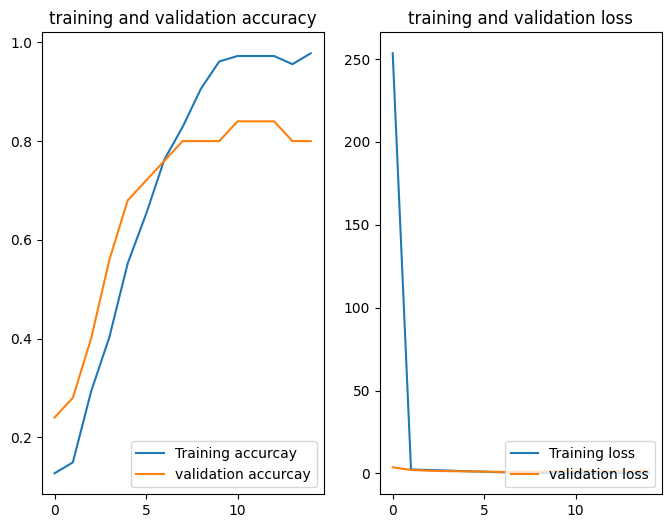

In [68]:
plt.figure(figsize = (8,6))
plt.subplot(1,2,1)
plt.plot(range(15), acc, label = "Training accurcay")
plt.plot(range(15), val_acc, label = "validation accurcay")
plt.legend(loc='lower right')
plt.title("training and validation accuracy")



plt.subplot(1,2,2)
plt.plot(range(15), loss, label = "Training loss")
plt.plot(range(15), val_loss, label = "validation loss")
plt.legend(loc='lower right')
plt.title("training and validation loss")

first image to predict
actual:   3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
predicted lable:  3


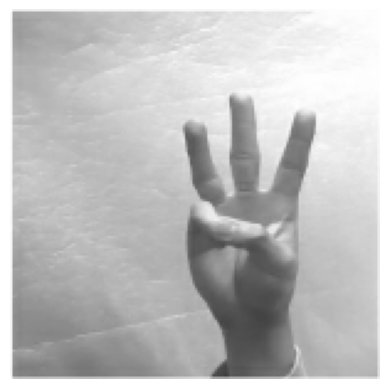

In [69]:
for image_batch, lable_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    plt.axis('off')
    first_lable = lable_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual:  ", class_names[first_lable])

    batch_prediction = model.predict(image_batch)
    print("predicted lable: ", class_names[np.argmax(batch_prediction[0])])
def predict (model, img):
    img_array = tensorflow.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tensorflow.expand_dims(img_array, 0) #create batch


    predictions = model.predict(img_array)

    predicted_class =class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


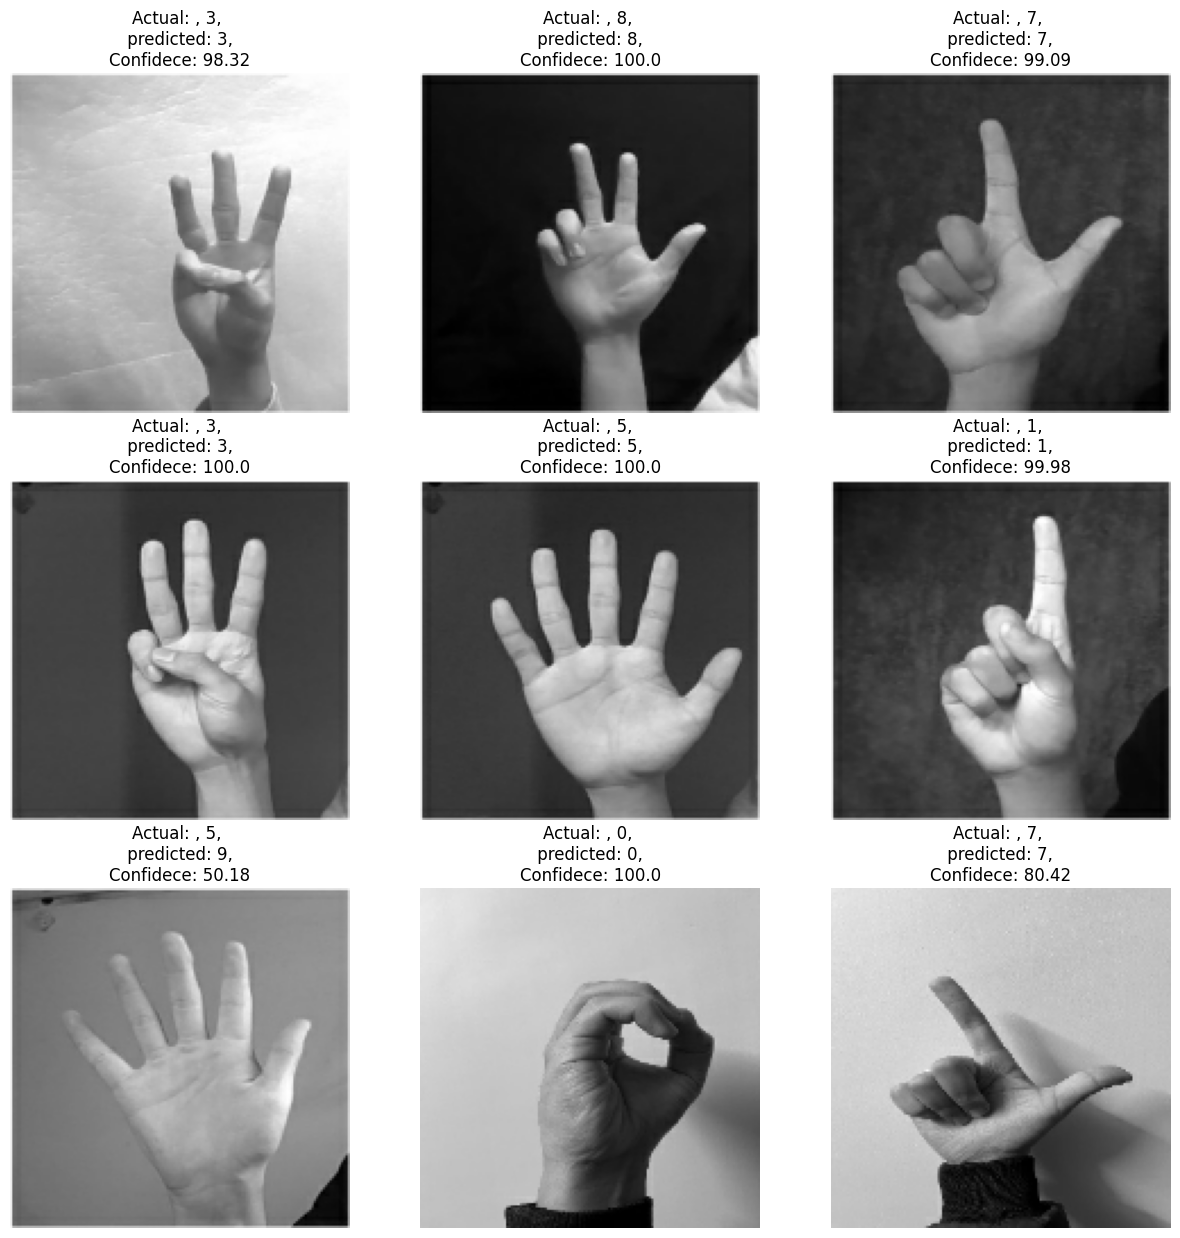

In [70]:
plt.figure(figsize=(15,15))
for images, lables in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[lables[i]]
        plt.title(f"Actual: , {actual_class}, \n predicted: {predicted_class}, \nConfidece: {confidence}")
        plt.axis('off')

In [71]:
model.save('my_model.keras')

print("Model saved successfully!")

Model saved successfully!


In [72]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.models import load_model

# Load the pre-trained model
model = load_model('my_model.keras')  # Update the path to your pre-trained model

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# Define class names
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']  # Update with your actual classes

# Start capturing video from the webcam
cap = cv2.VideoCapture(0)

# Define the codec and create a VideoWriter object to save the video
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640, 480))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame with MediaPipe hands solver
    results = hands.process(frame_rgb)

    # Draw landmarks and make predictions if hands are detected
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Draw hand landmarks on the frame
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # Extract hand region (bounding box)
            h, w, _ = frame.shape
            x_min = int(min([lm.x for lm in hand_landmarks.landmark]) * w)
            x_max = int(max([lm.x for lm in hand_landmarks.landmark]) * w)
            y_min = int(min([lm.y for lm in hand_landmarks.landmark]) * h)
            y_max = int(max([lm.y for lm in hand_landmarks.landmark]) * h)

            # Expand the bounding box slightly
            margin = 10
            x_min = max(0, x_min - margin)
            x_max = min(w, x_max + margin)
            y_min = max(0, y_min - margin)
            y_max = min(h, y_max + margin)

            # Crop and preprocess the hand region
            hand_region = frame[y_min:y_max, x_min:x_max]
            hand_region_resized = cv2.resize(hand_region, (150, 150))  # Adjust size to match model input
            hand_region_normalized = hand_region_resized / 255.0
            hand_region_input = np.expand_dims(hand_region_normalized, axis=0)

            # Make predictions using the pre-trained model
            predictions = model.predict(hand_region_input)
            predicted_class = np.argmax(predictions, axis=1)
            label = class_names[predicted_class[0]]

            # Display the prediction on the frame
            cv2.putText(frame, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Write the frame to the video file
    out.write(frame)

    # Display the output
    cv2.imshow('Hand Detection', frame)

    # Exit on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the VideoWriter object and camera
cap.release()
out.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━